# Recommendation System

This python notebook contains a recommendation system that recommends related cocktails among 425 unique cocktails.

There are hundreds of cocktails yet most people know only the famous ones. Additionally, it can be difficult for many people to try new cocktails they think they will love. Most of the people might hesitate to try something new when it comes to the cocktails, because there are many options with different ingredients. Our cocktail recommender system encourages people to try new flavours by utilizing data science and various cocktails in the database

## Setup

In [136]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
# From sklearn importing DictVectorizer: Transforms lists of feature-value mappings to vectors.
# Importing KernelPCA: Kernel Principal component analysis (KPCA).
# Importing itertools provides various functions that work on iterators. 

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import KernelPCA
import itertools

## Data Load & Feature Engineering 

Using **Bigquery** we select the ingredients from de database, the id (idDrink) and the name of the Drink (srtDrink)

In [138]:
%%bigquery base

SELECT 
    idDrink,
    strDrink,
    strIngredient1,
    strIngredient2,
    strIngredient3,
    strIngredient4,
    strIngredient5,
    strIngredient6,
    strIngredient7,
    strIngredient8,
    strIngredient9,
    strIngredient10,
    strIngredient11,
    strIngredient12,
    strIngredient13,
    strIngredient14,
    strIngredient15
FROM `bookish-journey-343419.cocktails_dataset.cocktails-table`

Downloading: 100%|██████████| 425/425 [00:01<00:00, 386.69rows/s]


In [139]:
# Print the first 10 rows of the database
print(base.shape)
base.head(10)

(425, 17)


,idDrink,strDrink,strIngredient1,strIngredient2,strIngredient3,strIngredient4,strIngredient5,strIngredient6,strIngredient7,strIngredient8,strIngredient9,strIngredient10,strIngredient11,strIngredient12,strIngredient13,strIngredient14,strIngredient15
0,11004,Whiskey Sour,Blended whiskey,Lemon,Powdered sugar,Cherry,Lemon,None,None,None,None,None,None,None,None,None,None
1,11009,Moscow Mule,Vodka,Lime juice,Ginger ale,None,None,None,None,None,None,None,None,None,None,None,None
2,11000,Mojito,Light rum,Lime,Sugar,Mint,Soda water,None,None,None,None,None,None,None,None,None,None
3,11008,Manhattan,Sweet Vermouth,Bourbon,Angostura bitters,Ice,Maraschino cherry,Orange peel,None,None,None,None,None,None,None,None,None
4,11003,Negroni,Gin,Campari,Sweet Vermouth,None,None,None,None,None,None,None,None,None,None,None,None
5,11014,Alexander,Gin,Creme de Cacao,Light cream,Nutmeg,None,None,None,None,None,None,None,None,None,None,None
6,11021,Allegheny,Dry Vermouth,Bourbon,Blackberry brandy,Lemon juice,Lemon peel,None,None,None,None,None,None,None,None,None,None
7,11020,Algonquin,Blended whiskey,Dry Vermouth,Pineapple juice,None,None,None,None,None,None,None,None,None,None,None,None
8,11005,Dry Martini,Gin,Dry Vermouth,Olive,None,None,None,None,None,None,None,None,None,None,None,None
9,11007,Margarita,Tequila,Triple sec,Lime juice,Salt,None,None,None,None,None,None,None,None,None,None,None


In [140]:
# Show the type of every column, you can see that from strIngredient12 to strIngredient15 are empty columns.
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   idDrink          425 non-null    int64 
 1   strDrink         425 non-null    object
 2   strIngredient1   425 non-null    object
 3   strIngredient2   425 non-null    object
 4   strIngredient3   361 non-null    object
 5   strIngredient4   237 non-null    object
 6   strIngredient5   154 non-null    object
 7   strIngredient6   83 non-null     object
 8   strIngredient7   45 non-null     object
 9   strIngredient8   4 non-null      object
 10  strIngredient9   2 non-null      object
 11  strIngredient10  1 non-null      object
 12  strIngredient11  1 non-null      object
 13  strIngredient12  0 non-null      object
 14  strIngredient13  0 non-null      object
 15  strIngredient14  0 non-null      object
 16  strIngredient15  0 non-null      object
dtypes: int64(1), object(16)
memory usag

In [141]:
# Drop empty columns
base = base.drop(['strIngredient12','strIngredient13','strIngredient14','strIngredient15'],axis=1)

In [142]:
# Replace NaN with ""

base = base.replace(np.nan,"")

In [143]:
# Create a ner variable, ingredients, that has all the previous ingredients together. 
base['ingredients'] = base[['strIngredient1','strIngredient2','strIngredient3','strIngredient4','strIngredient5',
        'strIngredient6','strIngredient7','strIngredient8','strIngredient9','strIngredient10','strIngredient11']].agg(','.join, axis=1)
base.ingredients

0      Blended whiskey,Lemon,Powdered sugar,Cherry,Le...
1                    Vodka,Lime juice,Ginger ale,,,,,,,,
2             Light rum,Lime,Sugar,Mint,Soda water,,,,,,
3      Sweet Vermouth,Bourbon,Angostura bitters,Ice,M...
4                     Gin,Campari,Sweet Vermouth,,,,,,,,
                             ...                        
420                Spiced rum,Ginger ale,Lime,Ice,,,,,,,
421    Rum,Grapefruit Juice,Maraschino Liqueur,Lime J...
422                 Red wine,Lemon-lime soda,Ice,,,,,,,,
423                            Coffee,Milk,Sugar,,,,,,,,
424    Tequila,Campari,Lime Juice,Orange Juice,Rosema...
Name: ingredients, Length: 425, dtype: object

In [144]:
# Function to transform letters to lowercase.

def lower(text):
    text=text.lower()
    return text

# Pass all words throw the funtion and append them
ingredients_low=[]
for i in base.ingredients:
    il=lower(i)
    ingredients_low.append(il)

base['ingredients']=ingredients_low
base.ingredients

0      blended whiskey,lemon,powdered sugar,cherry,le...
1                    vodka,lime juice,ginger ale,,,,,,,,
2             light rum,lime,sugar,mint,soda water,,,,,,
3      sweet vermouth,bourbon,angostura bitters,ice,m...
4                     gin,campari,sweet vermouth,,,,,,,,
                             ...                        
420                spiced rum,ginger ale,lime,ice,,,,,,,
421    rum,grapefruit juice,maraschino liqueur,lime j...
422                 red wine,lemon-lime soda,ice,,,,,,,,
423                            coffee,milk,sugar,,,,,,,,
424    tequila,campari,lime juice,orange juice,rosema...
Name: ingredients, Length: 425, dtype: object

In [145]:
# This function convert a list of ingredients into a dictionary, note: every ingredient gets a 1.
# this mean that the value of every key is 1. key:value

def convert_to_dict(lst):
    d = {} #empty dict
    for ingre in lst:
        d[ingre] = 1
    return d

In [146]:
# We use the function to convert every row into a dictionary. 
# 'vodka': 1, 'lime juice': 1... this will help us later to create a one hot encoding.
base['bagofwords'] = base.ingredients.str.split(',').apply(convert_to_dict)
print(base.bagofwords)

0      {'blended whiskey': 1, 'lemon': 1, 'powdered s...
1      {'vodka': 1, 'lime juice': 1, 'ginger ale': 1,...
2      {'light rum': 1, 'lime': 1, 'sugar': 1, 'mint'...
3      {'sweet vermouth': 1, 'bourbon': 1, 'angostura...
4      {'gin': 1, 'campari': 1, 'sweet vermouth': 1, ...
                             ...                        
420    {'spiced rum': 1, 'ginger ale': 1, 'lime': 1, ...
421    {'rum': 1, 'grapefruit juice': 1, 'maraschino ...
422    {'red wine': 1, 'lemon-lime soda': 1, 'ice': 1...
423          {'coffee': 1, 'milk': 1, 'sugar': 1, '': 1}
424    {'tequila': 1, 'campari': 1, 'lime juice': 1, ...
Name: bagofwords, Length: 425, dtype: object


In [147]:
# One Hot Encoding
# To find similarities between dishes and cluster cocktails using their ingredients, we will represent a recipe by a one-hot encoded vector 
# of its ingredients. We will be establishing a vocabulary of ingredients using a method ‘DictVectorizer’ provided in the sklearn library

# DictVectorizer:This transformer turns lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays or scipy.sparse matrices for use with scikit-learn estimators.
# sparse, default=True. Whether transform should produce scipy.sparse matrices. In this case we set it as False.

vector_dict = DictVectorizer(sparse = False)

# fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data. 
#The fit method is calculating the mean and variance of each of the features present in our data. 
#The transform method is transforming all the features using the respective mean and variance.
# We past every dictionary into a list.
X = vector_dict.fit_transform(base["bagofwords"].tolist())

# We select the column strDrink(name of the drink) from de dataset
y = base.strDrink

## KPCA Method

Kernel Principal Component Analysis (KPCA) is a non-linear dimensionality reduction technique. It is an extension of Principal Component Analysis (PCA) - which is a linear dimensionality reduction technique - using kernel methods.

In [155]:
# Using Kernel PCA
# kernel = "cosine": This is called cosine similarity, because Euclidean (L2) normalization projects the vectors onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

kpca = KernelPCA(n_components=2,kernel="cosine", n_jobs=2)

# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data. 
#Thus, the parameters learned by our model using the training data will help us to transform our test data.
x_pca = kpca.fit_transform(X)
x_pca.shape

(425, 2)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


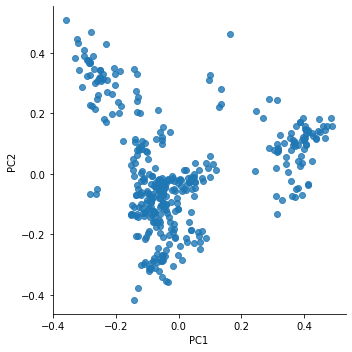

In [156]:
# Plotting the PCA decomposition
plot_pca = pd.DataFrame(data = x_pca[:,:2], columns = ["PC1","PC2"])
sns.lmplot("PC1", "PC2", data = plot_pca, palette = "Paired",legend=True, fit_reg = False)

## Mean Shift Clustering

In [157]:
from sklearn.cluster import MeanShift
ms = MeanShift().fit(x_pca)

In [158]:
ms.labels_

array([0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 0, 2,
       0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 0, 0,
       2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 1, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2,
       1, 0, 0, 0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 2, 0,
       0, 0, 2, 0, 2, 0, 1, 0, 2, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 0, 1, 2, 0, 2, 0,
       0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0,

In [159]:
# Fit.predict compute cluster centers and predict cluster index for each sample.
label = ms.fit_predict(x_pca)

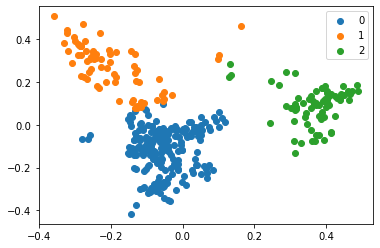

In [160]:
# Getting unique labels
u_labels = np.unique(label)
 
# Plotting the results:
for i in u_labels:
    plt.scatter(x_pca[label == i , 0] , x_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

In [165]:
# Recommendations
def cluster_recomm(index,algorithm = kmeans,n_return = 5):
    cluster = algorithm.predict(x_pca[index].reshape(1, -1))[0]
    cluster_map = pd.DataFrame()
    cluster_map['cluster'] = algorithm.labels_
    in_cluster = cluster_map[cluster_map.cluster == cluster].sample(n=n_return, random_state = 42)
    return y[in_cluster.index]

In [166]:
cluster_recomm(index = 6,algorithm = ms,n_return = 5)

58      John Collins
186    Midnight Manx
137        Downshift
323      Mocha-Berry
324      Masala Chai
Name: strDrink, dtype: object

## K-means

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

In [169]:
# Import KMeans library
from sklearn.cluster import KMeans
import numpy as np

In [170]:
# Using Kernel PCA
# kernel = "cosine": This is called cosine similarity, because Euclidean (L2) normalization projects the vectors onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

kpca = KernelPCA(n_components=6,kernel="cosine", n_jobs=2)

# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data. 
#Thus, the parameters learned by our model using the training data will help us to transform our test data.
x_pca = kpca.fit_transform(X)
x_pca.shape

(425, 6)

In [171]:
# n_cluster: The number of clusters to form as well as the number of centroids to generate
# random_state: Determines random number generation for centroid initialization. Use an int to make the randomness deterministic.
# labels_: ndarray of shape (n_samples,)
#Labels of each point
kmeans = KMeans(n_clusters=16, random_state=42).fit(x_pca)
kmeans.labels_

array([13,  4, 12, 14,  2,  2,  6,  3,  2,  3,  0,  3,  6,  3, 15,  2,  9,
       11,  3, 13, 13,  2, 12,  2, 11, 14,  6, 14,  1,  3,  2, 13,  2, 11,
        3, 13,  2,  3,  3,  2, 15,  4, 12, 12, 15, 10, 15, 15,  2, 15,  4,
       12, 15,  2,  7, 14, 13,  4, 10,  2, 13,  2,  5,  6,  3,  2,  3,  4,
        3,  3,  3, 15,  8,  2, 14, 14, 15,  2,  1,  4,  1,  2,  3, 12,  2,
        2,  2,  3,  3,  3,  2,  1,  7,  2, 10,  1, 15,  3, 10,  1,  0,  1,
        7,  2,  1, 13,  1, 13,  6,  5,  3,  1,  8, 12,  5,  5,  6, 10,  2,
       13,  6,  5,  3,  2,  3,  3,  0,  9,  4,  5,  3,  3,  7, 12,  3,  6,
        3,  3,  3,  2, 11, 14,  4,  4,  3,  4,  2,  0,  5,  4,  3, 12,  3,
        8,  3, 10,  3,  3,  7,  5,  1,  7,  2,  6,  7,  0,  3,  0,  7,  3,
        0, 12,  2,  4,  3,  6,  3,  3,  5,  3, 14,  3,  7,  3, 12,  5,  7,
        3,  3,  3,  6, 10,  1,  4,  5,  3,  7, 15,  5,  3,  7, 14, 11,  3,
        0,  4, 14,  5, 11,  5,  7,  3,  7,  4,  4, 14,  3,  3,  0,  7,  3,
        7, 14,  7,  7,  3

In [172]:
# Fit.predict compute cluster centers and predict cluster index for each sample.
label = kmeans.fit_predict(x_pca)

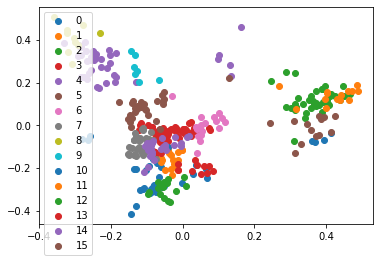

In [173]:
# Getting unique labels
u_labels = np.unique(label)
 
# Plotting the results:
for i in u_labels:
    plt.scatter(x_pca[label == i , 0] , x_pca[label == i , 1] , label = i)
plt.legend()
plt.show()

In [174]:
# Recommendations
def cluster_recomm(index,algorithm = kmeans,n_return = 5):
    cluster = algorithm.predict(x_pca[index].reshape(1, -1))[0]
    cluster_map = pd.DataFrame()
    cluster_map['cluster'] = algorithm.labels_
    in_cluster = cluster_map[cluster_map.cluster == cluster].sample(n=n_return, random_state = 42)
    return y[in_cluster.index]

In [175]:
cluster_recomm(index = 6,algorithm = kmeans,n_return = 5)

6           Allegheny
116      Tequila Fizz
236         Gagliardo
12           Applecar
163    Coke and Drops
Name: strDrink, dtype: object

## Cosine Distance

In [22]:
# Import library spatial
from scipy import spatial

# This function return the "n_return" similar cocktails, based in theri ingredients.

def get_cosine_distance(objective,n_return = 5):
  values = []
  for i in range(len(X)):
    values.append(1 - spatial.distance.cosine(objective, X[i]))
  ind = np.argpartition(values, -1 * n_return)[-1 * n_return:]
  top_n = y[ind]
  return top_n

In [23]:
# Example run of the above function.
get_cosine_distance(X[4])

293        French Negroni
15              Artillery
343                Victor
73     Lone Tree Cocktail
4                 Negroni
Name: strDrink, dtype: object

# References

https://plotly.com/python/pca-visualization/

https://programminghistorian.org/en/lessons/clustering-with-scikit-learn-in-python

https://medium.com/web-mining-is688-spring-2021/how-dishes-are-clustered-together-based-on-the-ingredients-3b357ac02b26

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://www.askpython.com/python/examples/plot-k-means-clusters-python

https://numpy.org/doc/stable/reference/generated/numpy.argpartition.html